# Setting-Up the environment

In [2]:
import pyspark

In [3]:
from pyspark import StorageLevel
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [4]:
spark= SparkSession.builder.appName('Practice_prj').getOrCreate()

# Extracting and Cleaning the Dataset

Since some of the app names have a double quotation mark, we should indicate to spark.read.csv that this character has to be escaped. This is to be done in order to get rid of one extra column perceived by spark.read.csv.

### Extraction of the concerned Dataset

In [5]:
df_pyspark= spark.read.csv("googlePS.csv", header=True, sep=',', escape='"', inferSchema=True)

Just to check, if the entries are correctly loaded or not.

In [6]:
df_pyspark.select("App").where("App like '%\"%'").show(truncate=False)

+------------------------------------------------------+
|App                                                   |
+------------------------------------------------------+
|Eat Fast Prepare "Without Internet"                   |
|Yanosik: "antyradar", traffic jams, navigation, camera|
|Alphabet "H" Passcode Lock Screen                     |
|Official QR Code® Reader "Q"                          |
|Women"s Health Tips(Breast,Face,Body,weight lose)     |
|"i DT" Fútbol. Todos Somos Técnicos.                  |
|The FN "Baby" pistol explained                        |
+------------------------------------------------------+



### Cleaning of our Dataset

In [7]:
df_pyspark.show(1)

+--------------------+--------------+------+-------+----+--------+----+-----+--------------+------------+---------------+---------------+---------------+
|                 App|      Category|Rating|Reviews|Size|Installs|Type|Price|Content Rating|      Genres|   Last Updated|Current Version|Android Version|
+--------------------+--------------+------+-------+----+--------+----+-----+--------------+------------+---------------+---------------+---------------+
|Photo Editor & Ca...|ART_AND_DESIGN|   4.1|    159| 19M| 10,000+|Free|    0|      Everyone|Art & Design|January 7, 2018|          1.0.0|   4.0.3 and up|
+--------------------+--------------+------+-------+----+--------+----+-----+--------------+------------+---------------+---------------+---------------+
only showing top 1 row



In [8]:
df_pyspark.printSchema()

root
 |-- App: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Reviews: string (nullable = true)
 |-- Size: string (nullable = true)
 |-- Installs: string (nullable = true)
 |-- Type: string (nullable = true)
 |-- Price: string (nullable = true)
 |-- Content Rating: string (nullable = true)
 |-- Genres: string (nullable = true)
 |-- Last Updated: string (nullable = true)
 |-- Current Version: string (nullable = true)
 |-- Android Version: string (nullable = true)



For this analysis, we don't need all the columns but only a few of them, so let's start by dropping unwanted columns and altering their datatypes therafter.

In [6]:
# Drop unwanted columns
df_spark = df_pyspark.drop("category", "size", "type", "content rating")

Now we are going to focus on the following points

1. Column renaming: Removing spaces.
2. Rating: Cast to Double.
2. Installs: Apply regexp to remove unwanted characters and cast to Integer.
3. Price: Apply regexp to remove unwanted characters and cast to Double.
4. Last updated: Cast to Date.

In [7]:
df_spark = df_spark.withColumnRenamed("Android Version", "Android_Version") \
    .withColumnRenamed("Current Version", "Current_Version") \
    .withColumnRenamed("Last Updated", "last_updated") \
    .withColumn("Rating", col("Rating").cast(DoubleType())) \
    .withColumn("Reviews", col("Reviews").cast(IntegerType())) \
    .withColumn("Installs", regexp_replace(col("Installs"), "[^0-9]", "")) \
    .withColumn("Installs", col("Installs").cast(IntegerType())) \
    .withColumn("Price", regexp_replace(col("Price"), "[$]", "")) \
    .withColumn("Price", col("Price").cast(DoubleType())) \
    .withColumn("last_updated", to_date('last_updated', 'MMM d, yyyy'))

In [8]:
# Filling/replacing NULL values with 0 in "Price" Column
df_spark = df_spark.fillna(0, "price")

datatypes being altered and after cleaning actions, the schema looks like this.

In [12]:
df_spark.printSchema()

root
 |-- App: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Installs: integer (nullable = true)
 |-- Price: double (nullable = false)
 |-- Genres: string (nullable = true)
 |-- last_updated: date (nullable = true)
 |-- Current_Version: string (nullable = true)
 |-- Android_Version: string (nullable = true)



Just to allign the date format of this version of pyspark with the updated one and to avoid the parser problem, spark.conf.set() should be used before show statement.

In [9]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")
df_spark.show(4)

+--------------------+------+-------+--------+-----+--------------------+------------+------------------+---------------+
|                 App|Rating|Reviews|Installs|Price|              Genres|last_updated|   Current_Version|Android_Version|
+--------------------+------+-------+--------+-----+--------------------+------------+------------------+---------------+
|Photo Editor & Ca...|   4.1|    159|   10000|  0.0|        Art & Design|  2018-01-07|             1.0.0|   4.0.3 and up|
| Coloring book moana|   3.9|    967|  500000|  0.0|Art & Design;Pret...|  2018-01-15|             2.0.0|   4.0.3 and up|
|U Launcher Lite –...|   4.7|  87510| 5000000|  0.0|        Art & Design|  2018-08-01|             1.2.4|   4.0.3 and up|
|Sketch - Draw & P...|   4.5| 215644|50000000|  0.0|        Art & Design|  2018-06-08|Varies with device|     4.2 and up|
+--------------------+------+-------+--------+-----+--------------------+------------+------------------+---------------+
only showing top 4 rows


#### Removing duplicate records:
According to the information that Kaggle shows about the dataset, there are 9660 unique values. Let's verify

In [10]:
#Create temporal variable dataset, for executing SQL statements
df_spark.createOrReplaceTempView("df")

In [11]:
# repeated apps
spark.sql("""
SELECT App, Rating, Reviews, Installs, Genres, Price, Android_Version, count(*) rep
FROM df
GROUP BY App, Rating, Reviews, Installs, Genres, Price, Android_Version
HAVING count(*) > 1
ORDER BY rep DESC
""").show()


+--------------------+------+-------+---------+--------------------+-----+------------------+---+
|                 App|Rating|Reviews| Installs|              Genres|Price|   Android_Version|rep|
+--------------------+------+-------+---------+--------------------+-----+------------------+---+
|Quizlet: Learn La...|   4.6| 211856| 10000000|           Education|  0.0|Varies with device|  4|
|           WatchESPN|   4.1| 288809| 10000000|              Sports|  0.0|        4.4 and up|  4|
|eBay: Buy & Sell ...|   4.4|2788923|100000000|            Shopping|  0.0|Varies with device|  4|
|                Nick|   4.2| 123279| 10000000|Entertainment;Mus...|  0.0|        4.4 and up|  4|
|CBS Sports App - ...|   4.3|  91031|  5000000|              Sports|  0.0|        5.0 and up|  4|
|          Skyscanner|   4.5| 481546| 10000000|      Travel & Local|  0.0|        4.4 and up|  4|
|         Google Keep|   4.4| 691474|100000000|        Productivity|  0.0|Varies with device|  4|
|Extreme Coupon Fi..

In the following example we can see one specific app with almost identical rows, the only difference is in the number of reviews and version (both current_ver and last_updated).

In [16]:
# One specific example
spark.sql("""
SELECT  App, Rating, Reviews, Installs, Price,
        Genres, Last_Updated, Current_Version, Android_Version,
        row_number() OVER (PARTITION BY App ORDER BY Reviews DESC) RN
FROM df
WHERE App = "Farm Heroes Saga"
""").show()

+----------------+------+-------+---------+-----+------+------------+---------------+---------------+---+
|             App|Rating|Reviews| Installs|Price|Genres|Last_Updated|Current_Version|Android_Version| RN|
+----------------+------+-------+---------+-----+------+------------+---------------+---------------+---+
|Farm Heroes Saga|   4.4|7615646|100000000|  0.0|Casual|  2018-08-07|          5.2.6|     2.3 and up|  1|
|Farm Heroes Saga|   4.4|7614415|100000000|  0.0|Casual|  2018-07-26|          5.1.8|     2.3 and up|  2|
|Farm Heroes Saga|   4.4|7614407|100000000|  0.0|Casual|  2018-07-26|          5.1.8|     2.3 and up|  3|
|Farm Heroes Saga|   4.4|7614271|100000000|  0.0|Casual|  2018-07-26|          5.1.8|     2.3 and up|  4|
|Farm Heroes Saga|   4.4|7614130|100000000|  0.0|Casual|  2018-07-26|          5.1.8|     2.3 and up|  5|
+----------------+------+-------+---------+-----+------+------------+---------------+---------------+---+



Finally, to remove duplicates we are going to use the SQL analytical function ROW_NUMBER() establishing one specific order, and keeping only the first row of each App.

In [12]:
df= spark.sql("""
Select c.* from 
(SELECT  App, Rating, Reviews, Installs, Price, Genres, Last_Updated, Current_Version, Android_Version,
        row_number() OVER (PARTITION BY App ORDER BY Reviews DESC) RN
FROM df)c
where RN=1
""")

df.show(4)

+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+---+
|                 App|Rating|Reviews|Installs|Price|Genres|Last_Updated|Current_Version|Android_Version| RN|
+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+---+
|"i DT" Fútbol. To...|   NaN|     27|     500|  0.0|Sports|  2017-10-07|           0.22|     4.1 and up|  1|
|              #NAME?|   3.5|    115|   10000|  0.0|Comics|  2018-07-13|         5.0.12|     5.0 and up|  1|
|+Download 4 Insta...|   4.5|  40467| 1000000|  0.0|Social|  2018-08-02|           5.03|     4.1 and up|  1|
|                  .R|   4.5|    259|   10000|  0.0| Tools|  2014-09-16|         1.1.06|     1.5 and up|  1|
+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+---+
only showing top 4 rows



In [18]:
df.count()

9660

The following Dataframe method will only remove completely identical rows by looking at all the columns. 
{df = df.dropDuplicates()}

In [13]:
# Re-check for the duplicate entries
df.createOrReplaceTempView("df_test")

spark.sql("""
SELECT app, rating, reviews, installs, genres, price, android_version, count(*) rep
FROM df_test
GROUP BY app, rating, reviews, installs, genres, price, android_version
HAVING count(*) > 1
""").show()

+---+------+-------+--------+------+-----+---------------+---+
|app|rating|reviews|installs|genres|price|android_version|rep|
+---+------+-------+--------+------+-----+---------------+---+
+---+------+-------+--------+------+-----+---------------+---+



# From User Reviews Table

In [14]:
reviews = spark.read.csv("googlePS_user.csv", sep = ',', header=True, escape='"', inferSchema=True)

In [15]:
reviews.show(4)

+--------------------+--------------------+---------+------------------+----------------------+
|                 App|   Translated_Review|Sentiment|Sentiment_Polarity|Sentiment_Subjectivity|
+--------------------+--------------------+---------+------------------+----------------------+
|10 Best Foods for...|I like eat delici...| Positive|                 1|           0.533333333|
|10 Best Foods for...|This help eating ...| Positive|              0.25|           0.288461538|
|10 Best Foods for...|                 nan|      nan|               nan|                   nan|
|10 Best Foods for...|Works great espec...| Positive|               0.4|                 0.875|
+--------------------+--------------------+---------+------------------+----------------------+
only showing top 4 rows



In [16]:
reviews.count()

64295

In [17]:
reviews.createOrReplaceTempView("reviews_test")

# Questions for bussiness decisions

In [24]:
df= df.drop("RN")
df.show(4)

+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+
|                 App|Rating|Reviews|Installs|Price|Genres|Last_Updated|Current_Version|Android_Version|
+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+
|"i DT" Fútbol. To...|   NaN|     27|     500|  0.0|Sports|  2017-10-07|           0.22|     4.1 and up|
|              #NAME?|   3.5|    115|   10000|  0.0|Comics|  2018-07-13|         5.0.12|     5.0 and up|
|+Download 4 Insta...|   4.5|  40467| 1000000|  0.0|Social|  2018-08-02|           5.03|     4.1 and up|
|                  .R|   4.5|    259|   10000|  0.0| Tools|  2014-09-16|         1.1.06|     1.5 and up|
+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+
only showing top 4 rows



In [25]:
reviews.show(4)

+--------------------+--------------------+---------+------------------+----------------------+
|                 App|   Translated_Review|Sentiment|Sentiment_Polarity|Sentiment_Subjectivity|
+--------------------+--------------------+---------+------------------+----------------------+
|10 Best Foods for...|I like eat delici...| Positive|                 1|           0.533333333|
|10 Best Foods for...|This help eating ...| Positive|              0.25|           0.288461538|
|10 Best Foods for...|                 nan|      nan|               nan|                   nan|
|10 Best Foods for...|Works great espec...| Positive|               0.4|                 0.875|
+--------------------+--------------------+---------+------------------+----------------------+
only showing top 4 rows



### Q1. Applications with at least 10000 reviews, at least 50000 installations and are supported on Android 4.0 and higher.


The major problem here is to know, how we gonna extract 4.0 and higher from the string datatype column 'Android_Version'.  

In [41]:
# By exracting and analzing the first 2 digits of the string 
spark.sql("""Select APP, Android_Version from df_test
where CAST(SUBSTRING(REGEXP_REPLACE(Android_Version,"[^0-9]",""), 0, 1) as INT) >= 4
""").show()

+--------------------+---------------+
|                 APP|Android_Version|
+--------------------+---------------+
|"i DT" Fútbol. To...|     4.1 and up|
|              #NAME?|     5.0 and up|
|+Download 4 Insta...|     4.1 and up|
|              /u/app|     4.1 and up|
|              058.ba|     4.2 and up|
|      1. FC Köln App|     4.4 and up|
|100 Doors of Revenge|     4.4 and up|
|     100+ C Programs|     4.0 and up|
|100000+ Messages ...|   4.0.3 and up|
|101 C Programming...|   4.0.3 and up|
|104 Looking for a...|     4.0 and up|
|                11st|     4.0 and up|
|12 Step Meditatio...|     4.1 and up|
|       14thStreetVet|   4.0.3 and up|
|1800 Contacts - L...|     5.0 and up|
|1LINE – One Line ...|     4.1 and up|
|1st Fed CI Mobile...|     4.1 and up|
|2000 AD Comics an...|   4.0.3 and up|
|2017 BN SM Sales ...|     4.1 and up|
|2017 EMRA Antibio...|   4.0.3 and up|
+--------------------+---------------+
only showing top 20 rows



In [42]:
spark.sql("""Select APP, Reviews, Installs, Android_Version from df_test
where Reviews>=10000 and Installs>=50000 
and CAST(SUBSTRING(REGEXP_REPLACE(Android_Version,"[^0-9]",""), 0, 1) as INT) >= 4
""").show()

+--------------------+--------+---------+---------------+
|                 APP| Reviews| Installs|Android_Version|
+--------------------+--------+---------+---------------+
|+Download 4 Insta...|   40467|  1000000|     4.1 and up|
|100 Doors of Revenge|  105766| 10000000|     4.4 and up|
|104 Looking for a...|   74359|  1000000|     4.0 and up|
|                11st|   48732| 10000000|     4.0 and up|
|1800 Contacts - L...|   23160|  1000000|     5.0 and up|
|1LINE – One Line ...|  214878| 10000000|     4.1 and up|
|2018Emoji Keyboar...|  115773| 10000000|     4.1 and up|
|21-Day Meditation...|   11506|   100000|     4.1 and up|
|2Date Dating App,...|   41605|   500000|   4.0.3 and up|
|2ndLine - Second ...|   15880|  1000000|     4.0 and up|
|30 Day Fitness Ch...|  471036| 10000000|     4.0 and up|
|365Scores - Live ...|  666521| 10000000|     4.1 and up|
|3D Blue Glass Wat...|   62209| 10000000|   4.0.3 and up|
|50000 Free eBooks...|   52312|  5000000|     4.4 and up|
|591 housing t

### Q2. Top 10 applications in regards to the highest number of positive sentiments.


In [28]:
spark.sql("""
Select APP, count(Sentiment) cnt
from reviews_test
where Sentiment='Positive'
group by APP
order by cnt desc
limit 10
""").show()

+--------------------+---+
|                 APP|cnt|
+--------------------+---+
|          Helix Jump|209|
|Duolingo: Learn L...|200|
|Calorie Counter -...|174|
|Calorie Counter -...|169|
|          Bowmasters|169|
|10 Best Foods for...|162|
|       Google Photos|143|
|8fit Workouts & M...|137|
|    Garena Free Fire|136|
| DRAGON BALL LEGENDS|127|
+--------------------+---+



### Q3. Histogram for the number of installations.

In [45]:
df= df.fillna(0, "Installs")

In [53]:
histogram= spark.sql("""
Select Installs, count(*) Frequency
from df_test
group by Installs
order by Installs
""")

histogram.show()

+----------+---------+
|  Installs|Frequency|
+----------+---------+
|         0|       16|
|         1|       67|
|         5|       82|
|        10|      385|
|        50|      204|
|       100|      709|
|       500|      328|
|      1000|      887|
|      5000|      468|
|     10000|     1030|
|     50000|      469|
|    100000|     1113|
|    500000|      504|
|   1000000|     1417|
|   5000000|      607|
|  10000000|      937|
|  50000000|      204|
| 100000000|      189|
| 500000000|       24|
|1000000000|       20|
+----------+---------+



For the ploting of Data we extracted, we need to convert the PySpark Dataframe to Pandas Dataframe in order to use the Pandas internal plot library.

In [54]:
# Conversion: Spark DF to Pandas DF
plotdf = histogram.toPandas()

<AxesSubplot:ylabel='Installs'>

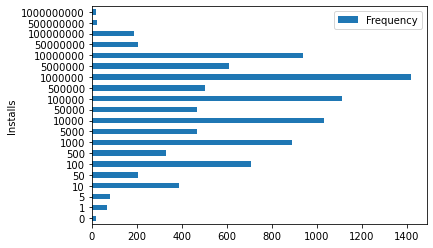

In [57]:
# Pandas internal plot library
plotdf.plot(kind='barh', x='Installs', y='Frequency')

### Q4. How many distinct genres there are? How many apps for each genre?

In [68]:
spark.sql("""
Select count(distinct Genres) cnt
from df_test
""").show()

+---+
|cnt|
+---+
|119|
+---+



In [65]:
spark.sql("""
Select distinct Genres, count(App) cnt
from df_test
group by Genres
order by cnt desc
""").show()

+-----------------+---+
|           Genres|cnt|
+-----------------+---+
|            Tools|828|
|    Entertainment|561|
|        Education|510|
|         Business|420|
|          Medical|395|
|  Personalization|376|
|     Productivity|374|
|        Lifestyle|368|
|          Finance|345|
|           Sports|331|
|    Communication|315|
|           Action|299|
| Health & Fitness|288|
|      Photography|281|
| News & Magazines|254|
|           Social|239|
|Books & Reference|222|
|   Travel & Local|218|
|         Shopping|202|
|       Simulation|193|
+-----------------+---+
only showing top 20 rows



### Q5. Apps with more positive Sentiments than negative and neutral together and having a Rating of at least 4.2.

In [69]:
df.show(4)

+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+
|                 App|Rating|Reviews|Installs|Price|Genres|Last_Updated|Current_Version|Android_Version|
+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+
|"i DT" Fútbol. To...|   NaN|     27|     500|  0.0|Sports|  2017-10-07|           0.22|     4.1 and up|
|              #NAME?|   3.5|    115|   10000|  0.0|Comics|  2018-07-13|         5.0.12|     5.0 and up|
|+Download 4 Insta...|   4.5|  40467| 1000000|  0.0|Social|  2018-08-02|           5.03|     4.1 and up|
|                  .R|   4.5|    259|   10000|  0.0| Tools|  2014-09-16|         1.1.06|     1.5 and up|
+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+
only showing top 4 rows



In [71]:
df.printSchema()

root
 |-- App: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Reviews: integer (nullable = true)
 |-- Installs: integer (nullable = true)
 |-- Price: double (nullable = false)
 |-- Genres: string (nullable = true)
 |-- Last_Updated: date (nullable = true)
 |-- Current_Version: string (nullable = true)
 |-- Android_Version: string (nullable = true)



In [85]:
df= df.fillna(0, "Rating")
df.show(4)

+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+
|                 App|Rating|Reviews|Installs|Price|Genres|Last_Updated|Current_Version|Android_Version|
+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+
|"i DT" Fútbol. To...|   0.0|     27|     500|  0.0|Sports|  2017-10-07|           0.22|     4.1 and up|
|              #NAME?|   3.5|    115|   10000|  0.0|Comics|  2018-07-13|         5.0.12|     5.0 and up|
|+Download 4 Insta...|   4.5|  40467| 1000000|  0.0|Social|  2018-08-02|           5.03|     4.1 and up|
|                  .R|   4.5|    259|   10000|  0.0| Tools|  2014-09-16|         1.1.06|     1.5 and up|
+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+
only showing top 4 rows



In [98]:
reviews.show(4)

+--------------------+--------------------+---------+------------------+----------------------+
|                 App|   Translated_Review|Sentiment|Sentiment_Polarity|Sentiment_Subjectivity|
+--------------------+--------------------+---------+------------------+----------------------+
|10 Best Foods for...|I like eat delici...| Positive|                 1|           0.533333333|
|10 Best Foods for...|This help eating ...| Positive|              0.25|           0.288461538|
|10 Best Foods for...|                 nan|      nan|               nan|                   nan|
|10 Best Foods for...|Works great espec...| Positive|               0.4|                 0.875|
+--------------------+--------------------+---------+------------------+----------------------+
only showing top 4 rows



#### Major Operation starts from here onwards

In [18]:
Sent_per_app= spark.sql("""
Select App, 
sum(case Sentiment when 'Positive' then 1 else 0 end) pos,
sum(case Sentiment when 'Negative' then 1 else 0 end) neg,
sum(case Sentiment when 'Neutral' then 1 else 0 end) neut
from reviews_test
where Sentiment!= 'nan'
group by App
""")

Sent_per_app.show(10)

+--------------------+---+---+----+
|                 App|pos|neg|neut|
+--------------------+---+---+----+
|BaBe+ - Berita In...| 13|  2|   5|
|    Basketball Stars| 44| 41|   4|
|Davis's Drug Guid...|  2|  0|   1|
|Bloomberg Profess...| 15| 11|  14|
|Bagan - Myanmar K...| 21|  2|   9|
|     Candy Pop Story| 22| 13|   5|
|Cricbuzz - Live C...| 26| 11|   1|
|AOL - News, Mail ...| 17|  7|   9|
|            Arrow.io| 53| 28|  14|
|CALCU™ Stylish Ca...| 27|  1|  10|
+--------------------+---+---+----+
only showing top 10 rows



In [19]:
Sent_per_app.createOrReplaceTempView("Sent_per_app")

In [20]:
pre_final= spark.sql("""
Select a.Rating, b.*
from df_test a inner join Sent_per_app b
ON a.App = b.App 
and Rating>= 4.2
""")
pre_final.show()

+------+--------------------+---+---+----+
|Rating|                 App|pos|neg|neut|
+------+--------------------+---+---+----+
|   4.4|    Basketball Stars| 44| 41|   4|
|   4.5|Davis's Drug Guid...|  2|  0|   1|
|   4.7|     Candy Pop Story| 22| 13|   5|
|   4.5|Cricbuzz - Live C...| 26| 11|   1|
|   4.5|            Arrow.io| 53| 28|  14|
|   4.7|CALCU™ Stylish Ca...| 27|  1|  10|
|   4.7|BELONG Beating Ca...| 28|  2|   8|
|   4.5|      Bubble Shooter|100| 40|   5|
|   4.5|All-in-One Mahjon...|  1|  0|   0|
|   4.3|     Amazon Shopping| 22| 13|  10|
|   4.5|Basketball FRVR -...| 16| 12|   7|
|   4.6|CM Launcher 3D - ...| 12|  2|   4|
|   4.3|Dog Licks Screen ...| 20|  5|   9|
|   4.6|Dream League Socc...|  2|  1|   0|
|   4.6|Drawing for Kids ...|  1|  0|   0|
|   4.2|         Blood Donor| 26|  2|  11|
|   4.8|Calculator with P...|  1|  0|   1|
|   4.7|  Domino's Pizza USA| 40| 11|   2|
|   4.5|2GIS: directory &...| 23|  6|  11|
|   4.3|         Alarm Clock| 22|  4|  10|
+------+---

In [21]:
pre_final.createOrReplaceTempView("pre_final")

In [22]:
spark.sql("""
Select *
from pre_final
where pos> neg+neut
order by pos desc
""").show()

+------+--------------------+---+---+----+
|Rating|                 App|pos|neg|neut|
+------+--------------------+---+---+----+
|   4.2|          Helix Jump|209| 58|   6|
|   4.7|Duolingo: Learn L...|200| 34|   6|
|   4.6|Calorie Counter -...|169| 52|  34|
|   4.7|          Bowmasters|169|119|  24|
|   4.5|       Google Photos|143| 47|   1|
|   4.6|8fit Workouts & M...|137| 19|  15|
|   4.5|    Garena Free Fire|136| 81|   5|
|   4.6| DRAGON BALL LEGENDS|127| 39|   1|
|   4.3|CBS Sports App - ...|123| 42|  27|
|   4.6|ColorNote Notepad...|121|  7|   3|
|   4.5|Calorie Counter -...|120|  4|  15|
|   4.3|Adobe Acrobat Reader|119| 28|  15|
|   4.5|Calorie Counter &...|109| 17|   9|
|   4.6|        Clash Royale|107| 58|   0|
|   4.6|    Alto's Adventure|103| 72|   0|
|   4.3|           Flow Free|101| 49|   4|
|   4.5|      Bubble Shooter|100| 40|   5|
|   4.6|Groupon - Shop De...| 95| 10|  15|
|   4.4|Family Locator - ...| 95|  7|  13|
|   4.3|Episode - Choose ...| 94| 48|  18|
+------+---

# Applying Machine Learning tool (Linear regression) on the Dataset 

In [125]:
df= df.drop("RN")
df= df.fillna(0, "Rating")
df.show(4)

+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+
|                 App|Rating|Reviews|Installs|Price|Genres|Last_Updated|Current_Version|Android_Version|
+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+
|"i DT" Fútbol. To...|   0.0|     27|     500|  0.0|Sports|  2017-10-07|           0.22|     4.1 and up|
|              #NAME?|   3.5|    115|   10000|  0.0|Comics|  2018-07-13|         5.0.12|     5.0 and up|
|+Download 4 Insta...|   4.5|  40467| 1000000|  0.0|Social|  2018-08-02|           5.03|     4.1 and up|
|                  .R|   4.5|    259|   10000|  0.0| Tools|  2014-09-16|         1.1.06|     1.5 and up|
+--------------------+------+-------+--------+-----+------+------------+---------------+---------------+
only showing top 4 rows



In [126]:
reviews.show(4)

+--------------------+--------------------+---------+------------------+----------------------+
|                 App|   Translated_Review|Sentiment|Sentiment_Polarity|Sentiment_Subjectivity|
+--------------------+--------------------+---------+------------------+----------------------+
|10 Best Foods for...|I like eat delici...| Positive|                 1|           0.533333333|
|10 Best Foods for...|This help eating ...| Positive|              0.25|           0.288461538|
|10 Best Foods for...|                 nan|      nan|               nan|                   nan|
|10 Best Foods for...|Works great espec...| Positive|               0.4|                 0.875|
+--------------------+--------------------+---------+------------------+----------------------+
only showing top 4 rows



In [165]:
# Forming a new dataset to implement ML operation

data= spark.sql("""
Select App, Price, Reviews, Installs
from df_test 
where Price!= 0 and Reviews!= 0 and Installs!=0
""")

data.show(4)

+--------------------+-----+-------+--------+
|                 App|Price|Reviews|Installs|
+--------------------+-----+-------+--------+
|10 WPM Amateur ha...| 1.49|     10|     100|
|10,000 Quotes DB ...| 0.99|     70|     500|
|17th Edition Cabl...| 3.08|     47|    1000|
|2 Amateur ham rad...| 1.49|      6|     100|
+--------------------+-----+-------+--------+
only showing top 4 rows



In [166]:
#changing the datatype of 'Sentiment_Polarity'

data.printSchema()

root
 |-- App: string (nullable = true)
 |-- Price: double (nullable = false)
 |-- Reviews: integer (nullable = true)
 |-- Installs: integer (nullable = true)



In [190]:
data.count()

678

In [170]:
# After dropping the 'na' values

data=data.na.drop()
data.count()

678

### Major Operation starts from here onwards

#### Giving Training to the Dataset

In [179]:
from pyspark.ml.feature import VectorAssembler
featureassembler= VectorAssembler(inputCols=['Installs', 'Reviews'], outputCol='Independent Features')

In [180]:
output= featureassembler.transform(data)
output.show(5)

+--------------------+-----+-------+--------+--------------------+
|                 App|Price|Reviews|Installs|Independent Features|
+--------------------+-----+-------+--------+--------------------+
|10 WPM Amateur ha...| 1.49|     10|     100|        [100.0,10.0]|
|10,000 Quotes DB ...| 0.99|     70|     500|        [500.0,70.0]|
|17th Edition Cabl...| 3.08|     47|    1000|       [1000.0,47.0]|
|2 Amateur ham rad...| 1.49|      6|     100|         [100.0,6.0]|
|2017 EMRA Antibio...|16.99|     12|    1000|       [1000.0,12.0]|
+--------------------+-----+-------+--------+--------------------+
only showing top 5 rows



In [181]:
final_data= output.select(['Independent Features', 'Price'])
final_data.show(10)

+--------------------+-----+
|Independent Features|Price|
+--------------------+-----+
|        [100.0,10.0]| 1.49|
|        [500.0,70.0]| 0.99|
|       [1000.0,47.0]| 3.08|
|         [100.0,6.0]| 1.49|
|       [1000.0,12.0]|16.99|
|        [100.0,12.0]| 1.49|
|          [10.0,8.0]| 0.99|
|          [10.0,1.0]| 1.49|
|         [100.0,7.0]| 9.99|
|      [1000.0,214.0]|33.99|
+--------------------+-----+
only showing top 10 rows



#### Applying Linear Regression to train the Dataset

In [182]:
from pyspark.ml.regression import LinearRegression

# train and test data split (75% of data to train_data and remaining 25% of data to test_data)

train_data, test_data= final_data.randomSplit([0.75, 0.25])
regressor= LinearRegression(featuresCol= 'Independent Features', labelCol= 'Price')
regressor= regressor.fit(train_data)

#### Its time to predict the "Price" on rem 25% dataset (test_data)

In [183]:
# Prediction on the remaining 25% (test_data) of the final_data

pred_result= regressor.evaluate(test_data)

In [189]:
pred_result.predictions.show(100)

+--------------------+------+------------------+
|Independent Features| Price|        prediction|
+--------------------+------+------------------+
|           [1.0,2.0]|  1.49| 13.28985459810176|
|          [10.0,1.0]|  0.99| 13.28982887446357|
|          [10.0,1.0]|  0.99| 13.28982887446357|
|          [10.0,1.0]|  4.99| 13.28982887446357|
|          [10.0,1.0]|  5.49| 13.28982887446357|
|          [10.0,1.0]|  5.99| 13.28982887446357|
|          [10.0,1.0]|  6.49| 13.28982887446357|
|          [10.0,1.0]| 29.99| 13.28982887446357|
|          [10.0,1.0]| 29.99| 13.28982887446357|
|          [10.0,2.0]|  1.99|13.289832965428893|
|          [10.0,3.0]|  0.99|13.289837056394218|
|          [10.0,3.0]|  2.49|13.289837056394218|
|          [10.0,4.0]| 14.99|13.289841147359542|
|          [50.0,1.0]|  1.99|13.289732729250831|
|          [50.0,2.0]|  1.76|13.289736820216156|
|          [50.0,2.0]|  2.99|13.289736820216156|
|          [50.0,2.0]|  3.99|13.289736820216156|
|          [50.0,3.0

In [186]:
pred_result.meanAbsoluteError, pred_result.meanSquaredError

(17.557489267909922, 3064.510217516199)

In [188]:
# Intercepts
regressor.intercept

13.28984881980143